In [2]:
# for data
from statsmodels.graphics.api import abline_plot
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

# for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.ensemble import GradientBoostingClassifier

# for explainer
from lime import lime_tabular

# for date
import datetime

# for HTTP
import requests

# for weather
import meteostat as met
from geopy.geocoders import Nominatim

# for dataframe nesting
from weatherData import WeatherData 

In [3]:
geolocator = Nominatim(user_agent="hke-tgki/0.1")
# districts = pd.DataFrame()

def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"


def prepareDtf(dtf):
    dtf.columns = dtf.columns.str.strip()
    cols = ["Bucket", "StartId", "StartName", "EndId", "EndName", "Count"]

    dtf = dtf[cols]
    dtf = dtf[dtf['Bucket'].str.len() == 10]
    dtf = dtf.groupby(["Bucket", "EndId", "EndName"])[
        "Count"].sum().reset_index()

    dtf["DoW"] = dtf["Bucket"].apply(
        lambda bucket: pd.to_datetime(bucket).day_name())

    dtf = dtf[dtf['Bucket'] >= '2020-04-01']

    dtf = dtf.rename(columns={"Count": "Y"})

    districts = dtf[['EndId', 'EndName']].copy()
    districts.drop_duplicates(subset = ["EndId"], inplace=True)
    districts["Coords"] = ""
    districts["Weather"] = ""
    for i in districts.index:
        point = getCoordsForDistrict(districts['EndName'][i])
        if (point == None): continue
        districts.loc[i,'Coords'] = point
        # districts['Coords'][i] = point
        
    return dtf, districts

def removeOutliers(dtf, factor): 
    maxVisitors = dtf.sort_values(by=['Y'])
    q1 = np.quantile(maxVisitors['Y'], 0.50)
    q3 = np.quantile(maxVisitors['Y'], 0.90)
    iqr = q3 - q1

    minValue = q1 - factor*iqr
    maxValue = q3 + factor*iqr

    print("minValue: ", minValue, "\nmaxValue: ", maxValue)

    dtf = dtf[dtf['Y'] >= minValue]
    dtf = dtf[dtf['Y'] <= maxValue]
    return dtf
    


def printHeatmap(dtf):
    dic_cols = {col: utils_recognize_type(
        dtf, col, max_cat=20) for col in dtf.columns}
    heatmap = dtf.isnull()
    for k, v in dic_cols.items():
        if v == "num":
            heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
        else:
            heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
    sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
    plt.show()
    print("\033[1;37;40m Categerocial ",
          "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")


def showKfoldValidation(model, x_train, y_train):
    scores = []
    cv = model_selection.KFold(n_splits=5, shuffle=True)
    fig = plt.figure()
    i = 1
    for train, test in cv.split(x_train, y_train):
        prediction = model.fit(x_train[train],
                               y_train[train]).predict(x_train[test])
        true = y_train[test]
        score = metrics.r2_score(true, prediction)
        scores.append(score)
        plt.scatter(prediction, true, lw=2, alpha=0.3,
                    label='Fold %d (R2 = %0.2f)' % (i, score))
        i = i+1
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)],
             linestyle='--', lw=2, color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('K-Fold Validation')
    plt.legend()
    plt.show()


def scaleData(dtf, y):
    # scale X
    scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
    X = scalerX.fit_transform(dtf.drop("Y", axis=1))
    dtf_scaled = pd.DataFrame(X, columns=dtf.drop(
        y, axis=1).columns, index=dtf.index)

    # scale Y
    scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
    dtf_scaled[y] = scalerY.fit_transform(
        dtf[y].values.reshape(-1, 1))

    return dtf_scaled, scalerX, scalerY


def unscaleData(scalerY, predicted, y_test):
    predicted = scalerY.inverse_transform(
        predicted.reshape(-1, 1)).reshape(-1)
    y_test = scalerY.inverse_transform(
        y_test.reshape(-1, 1)).reshape(-1)
    return predicted, y_test


def printKPI(predicted, y_test):
    print("R2 (explained variance):", round(
        metrics.r2_score(y_test, predicted), 3) * 100, "%")
    print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):",
          round(np.mean(np.abs((y_test-predicted)/predicted)), 3) * 100, "%")
    print("Mean Absolute Error (Σ|y-pred|/n):",
          "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
    print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):",
          "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(Y_test, predicted))))



def computeResiduals(predicted, y_test):
    residuals = y_test - predicted
    max_error = max(residuals) if abs(max(residuals)) > abs(
        min(residuals)) else min(residuals)
    max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(
        min(residuals)) else list(residuals).index(min(residuals))
    max_true, max_pred = y_test[max_idx], predicted[max_idx]
    print("Max Error:", "{:,.0f}".format(max_error))
    return residuals, max_error, max_idx, max_true, max_pred

def printMaxErrorY(predicted, y_test):
    max_difference_y = 0
    max_dif = 0
    for idx, val in enumerate(y_test):
        dif = abs(val - predicted[idx])
        if(dif > max_dif):
            max_dif = dif
            max_difference_y = val
    print("Max Error Y: ", dtf.loc[dtf['Y'] == max_difference_y])


def plotPredictionKPI(predicted, y_test, max_error, max_true, max_pred):
    # Plot predicted vs true
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].scatter(predicted, Y_test, color="black")
    abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
    ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error,
                 color='red', linestyle='--', alpha=0.7, label="max error")
    ax[0].grid(True)
    ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
    ax[0].legend()

    # Plot predicted vs residuals
    ax[1].scatter(predicted, residuals, color="red")
    ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black',
                 linestyle='--', alpha=0.7, label="max error")
    ax[1].grid(True)
    ax[1].set(xlabel="Predicted", ylabel="Residuals",
              title="Predicted vs Residuals")
    ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
    ax[1].legend()
    plt.show()


def plotResidualDistribution(residuals):
    fig, ax = plt.subplots()
    sns.distplot(residuals, color="red", hist=True,
                 kde=True, kde_kws={"shade": True}, ax=ax)
    ax.grid(True)
    ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
    plt.show()


def getFreeDays(year):
    # Request free days from Feiertage API for year 2021 in bavaria
    free_days = requests.get(
        f'https://feiertage-api.de/api/?jahr={year}&nur_land=BY')

    # Parse result and store as [key, val] dict
    free_days = free_days.json()

    free_day_dates = []

    # Iterate over
    for free_day_name in free_days:
        free_day_dates.append(free_days[free_day_name]['datum'])

    return free_day_dates

def getHolidays(year):
# Request free days from Feiertage API for year 2021 in bavaria
    holidays = requests.get(
    f'https://ferien-api.de/api/v1/holidays/BY/{year}')

    # Parse result and store as [key, val] dict
    holidays = holidays.json()

    holiday_dates = []

    # Iterate over
    for holiday in holidays:
        holiday_dates.append((holiday['start'], holiday['end']))

    return holiday_dates

def getCoordsForDistrict(districtName):
    location = geolocator.geocode(districtName)
    if (location == None):
        print(districtName)
        return None
    return met.Point(location.latitude, location.longitude)

def getTravellingDates(year, timespan): 
    holiday_dates = getHolidays(year)

    travelling_datestrings = []

    for date in holiday_dates:
        start = datetime.datetime.strptime(date[0], "%Y-%m-%dT%H:%MZ")
        end = datetime.datetime.strptime(date[1], "%Y-%m-%dT%H:%MZ")
        for i in range(0, timespan-1, 1):
            travelling_datestrings.append(datetime.datetime.strftime(start + datetime.timedelta(days=i), "%Y-%m-%d"))
            travelling_datestrings.append(datetime.datetime.strftime(end - datetime.timedelta(days=i),"%Y-%m-%d" ))

    return travelling_datestrings

def getWeatherData(dtf, districts):
    # Set time period
    start = datetime.datetime.strptime(dtf.iloc[1]['Bucket'], "%Y-%m-%d")
    end = datetime.datetime.strptime(dtf.iloc[-1]['Bucket'], "%Y-%m-%d")

    for i in districts.index:
        districts.loc[i,'Weather'] = WeatherData(met.Daily(districts['Coords'][i], start, end).fetch())

def addWeatherData(dtf, districts): 
    # Plot line chart including average, minimum and maximum temperature
    # data.plot(y=['tmax', 'prcp'])
    # plt.show()
    dtf["MaxTemp"] = ""
    dtf["Precip"] = ""

    for i in dtf.index:
        id = dtf.loc[i, 'EndId']
        time = dtf.loc[i, 'Bucket']
        weatherData = districts.loc[(districts.EndId == id),'Weather'].values[0]
        # print(weatherData.data.head())
        # print(weatherData.data.index.strftime("%Y-%m-%d"))
        # print(pd.Timestamp(time))
        # print(weatherData.data.index[0])
        # print(pd.Timestamp(time) == weatherData.data.index[0])
        # print(weatherData.data.loc[(weatherData.data.index == pd.Timestamp(time)), 'tmax'].values[0])
        if(weatherData.data.loc[(weatherData.data.index == pd.Timestamp(time))].size < 1):
            continue
        dtf.loc[i, 'MaxTemp'] = weatherData.data.loc[(weatherData.data.index == pd.Timestamp(time)), 'tmax'].values[0]
        dtf.loc[i, 'Precip'] = weatherData.data.loc[(weatherData.data.index == pd.Timestamp(time)), 'prcp'].values[0]
        # if i > 2: break


In [4]:
dtf = pd.read_csv("../data/mobilityDataAllgau.csv")

dtf, districts = prepareDtf(dtf)

Rostock - Ortsbeirat 18 : Gehlsdrf,Hinrichsdorf,Jürgenshof,Krummendorf,Nienhagen,Peez,Stuthof


In [5]:
getWeatherData(dtf, districts)

In [6]:
addWeatherData(dtf, districts)

In [8]:
print(dtf.shape[0])
dtf.replace([np.inf, -np.inf], np.nan, inplace=True)
dtf.replace("", float("NaN"), inplace=True)
dtf.dropna(how='all', axis=1, inplace=True)
print(dtf.shape[0])


95418
95418


In [10]:
dtf.to_csv("../data/mobilityDataAllgau_extended.csv")

In [17]:
dtf = pd.read_csv("../data/mobilityDataAllgau_extended.csv")
dtf.head()

,Unnamed: 0,Bucket,EndId,EndName,Y,DoW,MaxTemp,Precip
0,34472,2020-04-01,2701700,Rendsburg-Eckernförde,7,Wednesday,8.4,0.2
1,34473,2020-04-01,6233900,Saale-Orla-Kreis,32,Wednesday,7.5,0.0
2,34474,2020-04-01,6234000,Baden-Baden,7,Wednesday,11.6,0.0
3,34475,2020-04-01,6234300,Rheinisch-Bergischer Kreis,7,Wednesday,11.7,0.0
4,34476,2020-04-01,6234400,Rottweil - Landkreis Rottweil,67,Wednesday,10.1,0.0


In [18]:
# define clusters (workingday/weekend)
x = "Day"
Day_clusters = {"free": ["Saturday", "Sunday"], "work": ["Monday", "Tuesday", "Wednesday",
                                                         "Thursday", "Friday"]}
# create DoW_class columns
dic_flat = {v: k for k, lst in Day_clusters.items() for v in lst}
for k, v in Day_clusters.items():
    if len(v) == 0:
        residual_class = k
dtf[x+"_class"] = dtf['DoW'].apply(lambda x: dic_flat[x] if x in
                                   dic_flat.keys() else residual_class)

# create dummies Day_class
dummy = pd.get_dummies(dtf["Day_class"],
                       prefix="Day_class", drop_first=True)
dtf = pd.concat([dtf, dummy], axis=1)
# holidays = getHolidays(dtf['Bucket'].iloc(0)[:4])
freeDays = getFreeDays('2020')
for day in freeDays:
    dtf.loc[(dtf.Bucket == day), 'Day_class_work'] = 0

travellingDays = getTravellingDates('2020', 4)
dtf['Day_class_travel'] = 0
for day in travellingDays:
    dtf.loc[(dtf.Bucket == day), 'Day_class_travel'] = 1
    
# drop the original categorical column
dtf = dtf.drop("Day_class", axis=1)

dtf.head()


# create dummies DoW
dummy = pd.get_dummies(dtf["DoW"],
                       prefix="DoW", drop_first=False)
dtf = pd.concat([dtf, dummy], axis=1)
# drop the original categorical column
dtf = dtf.drop("DoW", axis=1)


# create dummes EndId
dummy = pd.get_dummies(dtf["EndId"],
                       prefix="EndId", drop_first=False)
dtf = pd.concat([dtf, dummy], axis=1)
# drop the original categorical column
# dtf = dtf.drop("EndId", axis=1)

In [19]:
# define training and test features
DoWColumns = [col for col in dtf if col.startswith('DoW_')]
DayColumns = [col for col in dtf if col.startswith('Day_')]
WeatherColumns = ["MaxTemp", "Precip"]
EndIdColumns = [col for col in dtf if col.startswith('EndId_')]
X_names = DoWColumns + DayColumns + EndIdColumns + WeatherColumns

# DEBUG
# X_names = ['Day_class_travel'] + EndIdColumns

relevantDtf = dtf[X_names + ["Y"]]
dtf_scaled, scalerX, scalerY = scaleData(relevantDtf, "Y")
# dtf_scaled = relevantDtf  # no scaling

# split data
dtfTrain, dtfTest = model_selection.train_test_split(dtf_scaled,
                                                     test_size=0.3)

X_train = dtfTrain[X_names].values
Y_train = dtfTrain["Y"].values
X_test = dtfTest[X_names].values
Y_test = dtfTest["Y"].values

In [20]:
# call model
# model = linear_model.LinearRegression()
model = ensemble.GradientBoostingRegressor()

# showKfoldValidation(model, X_train, Y_train)

# train
model.fit(X_train, Y_train)
# test
predicted = model.predict(X_test)
# unscale data to compare with actual data
predicted, Y_test = unscaleData(scalerY, predicted, Y_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

R2 (explained variance): 92.80000000000001 %
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 91.0 %
Mean Absolute Error (Σ|y-pred|/n): 1,657
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 11,239
Max Error: 284,680
Max Error Y:             Bucket    EndId                            EndName       Y  \
53707  2020-06-12  6241500  Oberallgäu - Landkreis Oberallgäu  884016   

       MaxTemp  Precip  Day_class_work  Day_class_travel  DoW_Friday  \
53707     25.4     0.0               1                 1           1   

       DoW_Monday  ...  EndId_280639000  EndId_280662300  EndId_280877400  \
53707           0  ...                0                0                0   

       EndId_281285000  EndId_281285100  EndId_281285200  EndId_667985900  \
53707                0                0                0                0   

       EndId_667985901  EndId_667985902  EndId_667985903  
53707                0                0                0  

[1 rows x 528 columns]


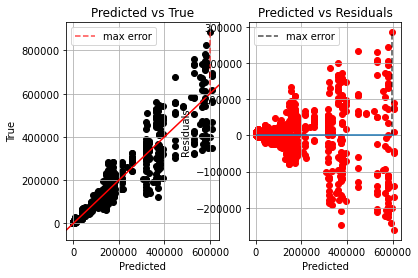

In [ ]:
printKPI(predicted, Y_test)

# residuals
residuals, max_error, max_idx, max_true, max_pred = computeResiduals(
    predicted, Y_test)

printMaxErrorY(predicted, Y_test)


plotPredictionKPI(predicted, Y_test, max_error, max_true, max_pred)